In [1]:
import sys
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi, voronoi_plot_2d
from tsp import AnnealingSolver
from mst_prim import prim_mst, createRoutes
from leach import LeachSolver
from nemo import evaluate_nemo
import util
from util import lighten_color
import seaborn as sns
from util import centroid_label, ch_label, coordinator_label, worker_label, ccolor, cmarker
from topology import get_lognorm_hist
import topology

#### Topology Setup

In [2]:
seed = 4
np.random.seed(seed)

avg = 50
c_capacity = 50

H, bins = get_lognorm_hist()
coords_df = topology.coords_ripe_atlas()
coord_dict = {"atlas": coords_df}
device_number = coords_df.shape[0]
max_resources = device_number * avg - c_capacity

df_dict_topologies = topology.create_topologies_from_dict(coord_dict, H, max_resources, c_capacity,
                                                          weights=(1, avg * 2), dist="lognorm", with_clustering=True,
                                                          kmin=2, kmax=30, kseed=10)

Creating df for atlas
Optimal k is 7
Done


In [3]:
t_label = "atlas"
prim_df, c_coords, base_col, slot_columns, centroids, opt_k, sil = df_dict_topologies[t_label]
prim_df["weight_1"] = 1
prim_df["weight_2"] = 2
coords = prim_df[["x", "y"]].to_numpy()

eval_matrix = {}
prim_df

,x,y,latency,type,base,weight,capacity_100,capacity_90,capacity_80,capacity_70,...,capacity_50,capacity_40,capacity_30,capacity_20,capacity_10,capacity_5,capacity_1,cluster,weight_1,weight_2
0,-93.917515,202.161843,0.000000,coordinator,522729,0,50,50,50,50,...,50,50,50,50,50,50,50,-1,1,2
1,-133.101399,-123.417988,327.929265,worker,522729,12,50,49,50,54,...,54,54,94,33,18,147,4,5,1,2
2,77.039491,-208.571409,444.891113,worker,522729,1,50,53,50,50,...,50,49,32,34,60,11,81,5,1,2
3,-185.479238,102.680454,135.203905,worker,522729,2,50,53,54,60,...,69,38,45,57,25,18,52,6,1,2
4,-159.584229,-110.718603,319.697186,worker,522729,3,50,49,47,52,...,50,59,34,35,23,13,195,5,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
718,-36.457796,-36.644464,245.621806,worker,522729,15,50,53,54,46,...,38,45,59,31,86,38,199,0,1,2
719,5.153206,17.416845,209.632349,worker,522729,7,50,48,46,45,...,39,43,49,30,16,79,15,0,1,2
720,-11.880711,-3.653801,221.562895,worker,522729,1,50,50,54,46,...,40,37,28,48,78,33,34,0,1,2
721,-25.491140,-9.502637,222.450041,worker,522729,4,50,50,54,52,...,36,66,38,30,76,28,8,0,1,2


In [4]:
print("Required:", prim_df["weight"].sum(), "Available:", prim_df["capacity_100"].sum())
colors, light_colors, palette = util.get_color_list(opt_k)
palette

Required: 5109 Available: 36150


[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902)]

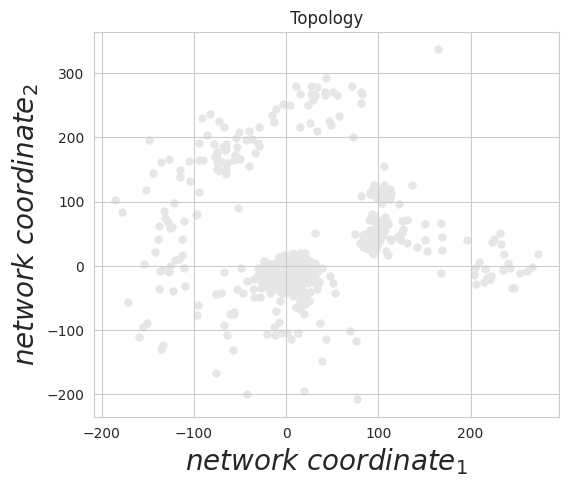

In [187]:
X_dim_def = [-50, 50]
Y_dim_def = [-60, 60]

fig, (ax1) = plt.subplots(1, 1, figsize=(6, 5))
ax1 = util.plot_topology(ax1, prim_df, show_legend=False, show_coordinator=False)

#ax1.set_xlim(X_dim_def)
#ax2.set_xlim(X_dim_def)

#ax1.set_ylim(Y_dim_def)
#ax2.set_ylim(Y_dim_def)

X_dim = ax1.get_xlim()
Y_dim = ax1.get_ylim()

plt.savefig("plots/atlas/atlas_ncs_plain.svg", bbox_inches="tight")

plt.show()

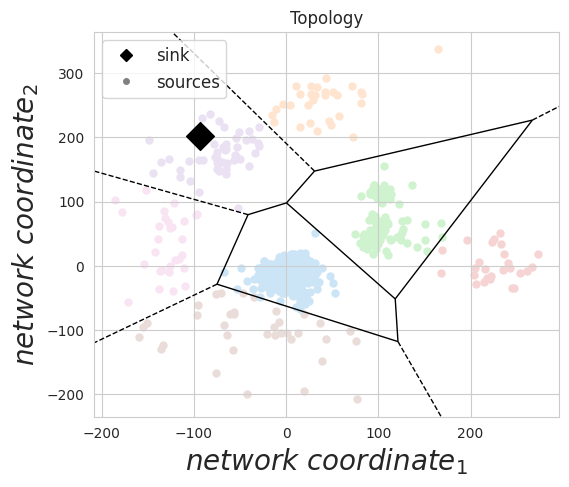

In [188]:
fig, (ax1) = plt.subplots(1, 1, figsize=(6, 5))

ax1 = util.plot_topology(ax1, prim_df, colors, 'Topology (k=' + str(opt_k) + ")")

ax1.set_xlim(X_dim)
ax1.set_ylim(Y_dim)

# plt.savefig("plots/atlas/atlas_ncs_colored.svg", bbox_inches="tight")

plt.show()

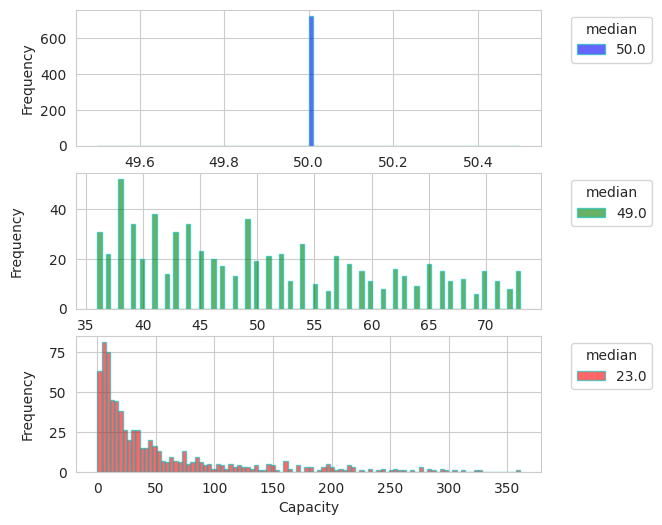

In [8]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(6, 6))

i = 100
prim_df["capacity_" + str(i)].plot.hist(ax=ax1, bins=100, alpha=0.6, color='b', ec='c',
                                        label=prim_df["capacity_" + str(i)].median())

i = 50
prim_df["capacity_" + str(i)].plot.hist(ax=ax2, bins=100, alpha=0.6, color='g', ec='c',
                                        label=prim_df["capacity_" + str(i)].median())

i = 1
prim_df["capacity_" + str(i)].plot.hist(ax=ax3, bins=100, alpha=0.6, color='r', ec='c',
                                        label=prim_df["capacity_" + str(i)].median())

ax1.legend(title='median', bbox_to_anchor=(1.05, 1), loc='upper left')
ax2.legend(title='median', bbox_to_anchor=(1.05, 1), loc='upper left')
ax3.legend(title='median', bbox_to_anchor=(1.05, 1), loc='upper left')
ax3.set_xlabel("Capacity")

# Set y-axis label with padding
ax2.set_ylabel("Frequency", labelpad=18)
ax3.set_ylabel("Frequency", labelpad=10)
plt.savefig("plots/sim_1000/capacity_dist.svg", bbox_inches="tight")

plt.show()

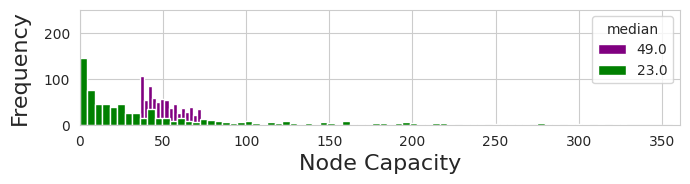

In [9]:
fig, (merged_ax) = plt.subplots(1, 1, figsize=(7, 2))

i = 50
prim_df["capacity_" + str(i)].plot.hist(ax=merged_ax, bins=15, alpha=1, color='purple',
                                        label=prim_df["capacity_" + str(i)].median())

#i = 10
#prim_df["capacity_"+str(i)].plot.hist(ax=merged_ax, bins=40, alpha=1, color='orange', label=prim_df["capacity_"+str(i)].median())

i = 1
prim_df["capacity_" + str(i)].plot.hist(ax=merged_ax, bins=80, alpha=1, color='green',
                                        label=prim_df["capacity_" + str(i)].median())

merged_ax.legend(title='median', loc='upper right')
merged_ax.set_xlabel("Node Capacity")

# Set y-axis label with padding
merged_ax.set_ylabel("Frequency", labelpad=10)

# Set the same x-axis limits for both histograms
xlim = (prim_df["capacity_1"].min(), prim_df["capacity_1"].max())
merged_ax.set_xlim(xlim)
merged_ax.set_ylim([0, 250])

merged_ax.yaxis.label.set_size(16)
merged_ax.xaxis.label.set_size(16)
#merged_ax.tick_params(axis='x', labelsize=20)

# Adjust figure layout for better display
fig.tight_layout()

plt.savefig("plots/atlas/capacity_dist.svg", bbox_inches="tight")
plt.show()

Medians from  50  to  25


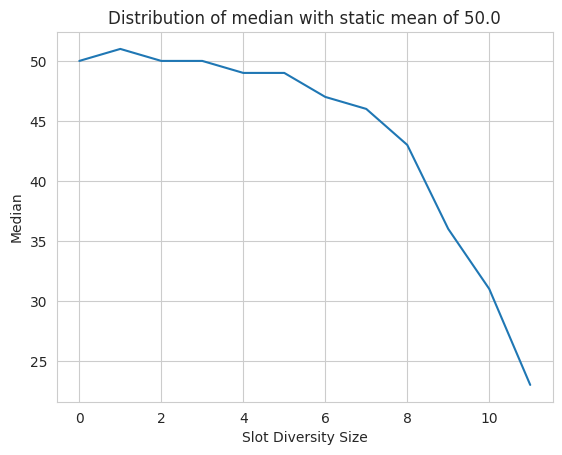

In [10]:
medians = []
mean = np.floor(prim_df["capacity_" + str(1)].mean())

for col in slot_columns:
    medians.append(prim_df[col].median())

medians = np.array(medians)
plt.plot(np.arange(len(medians)), medians)

first_med_label = "50"
last_med_label = "25"
print("Medians from ", first_med_label, " to ", last_med_label)

#print(load_dict)
plt.title("Distribution of median with static mean of " + str(mean))
plt.ylabel("Median")
plt.xlabel("Slot Diversity Size")
plt.show()

### Experiment 1: Send all data directly to coordinator


In [11]:
#first node is the coordinator
latency_hist = np.zeros(device_number)

for i in range(0, device_number):
    #calculate euclidean distance which corresponds to the cost space (latency)
    latency_hist[i] = np.linalg.norm(coords[i] - c_coords)

received_packets_hist = np.zeros(device_number)
for i in range(1, device_number):
    #coordinator receives 1 packet from each
    received_packets_hist[0] = received_packets_hist[0] + 1

statistics = {"latency_distribution": latency_hist,
              "received_packets": received_packets_hist}
df_stats = pd.DataFrame(statistics)
print(df_stats)
eval_matrix["dt"] = df_stats.copy()

     latency_distribution  received_packets
0                0.000000             722.0
1              327.929265               0.0
2              444.891113               0.0
3              135.203905               0.0
4              319.697186               0.0
..                    ...               ...
718            245.621806               0.0
719            209.632349               0.0
720            221.562895               0.0
721            222.450041               0.0
722            270.218262               0.0

[723 rows x 2 columns]


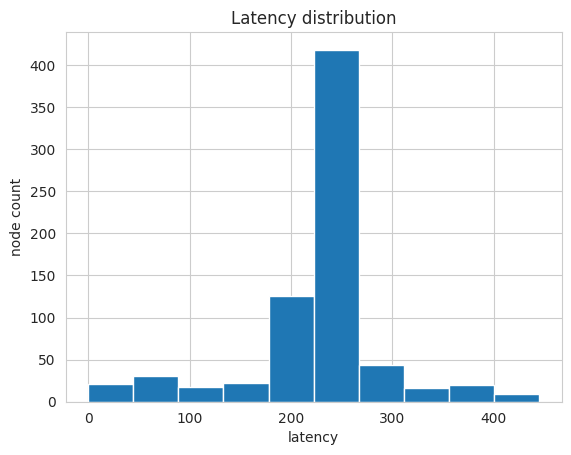

In [12]:
df_stats["latency_distribution"].hist()
plt.xlabel("latency")
plt.ylabel("node count")
plt.title("Latency distribution")
plt.show()

In [13]:
df_packets = df_stats.loc[df_stats["received_packets"] > 0]["received_packets"]
print("Distribution of workload: ", 1, "/", device_number, "=", round(len(df_packets) / device_number * 100, 5), "%")

Distribution of workload:  1 / 723 = 0.13831 %


### Experiment 1: LEACH Protocol

In [14]:
seed = 10
np.random.seed(seed)
latency_hist_sum = None
received_packets_hist_sum = None
leach_runs = 20
run = 1
df_stats_leach = []
num_leach_clusters = int(0.1*device_number)

for i in range(leach_runs):
    print("LEACH run", run)
    if run == leach_runs:
        leachSolver = LeachSolver(prim_df, num_leach_clusters, coords, seed=seed)
    else:
        leachSolver = LeachSolver(prim_df, num_leach_clusters, coords)

    leach_labels, ch_indexes, latency_hist, received_packets_hist = leachSolver.leachClustering()

    if latency_hist_sum is None:
        latency_hist_sum = latency_hist
    else:
        latency_hist_sum = latency_hist_sum + latency_hist

    statistics = {"latency_distribution": latency_hist,
                  "received_packets": received_packets_hist}
    df_stats = pd.DataFrame(statistics)
    df_stats_leach.append(df_stats.copy())
    run = run + 1

print("Number of clusters = ", len(ch_indexes))
print(ch_indexes)

LEACH run 1
LEACH run 2
LEACH run 3
LEACH run 4
LEACH run 5
LEACH run 6
LEACH run 7
LEACH run 8
LEACH run 9
LEACH run 10
LEACH run 11
LEACH run 12
LEACH run 13
LEACH run 14
LEACH run 15
LEACH run 16
LEACH run 17
LEACH run 18
LEACH run 19
LEACH run 20
Number of clusters =  72
[586, 34, 440, 495, 592, 16, 212, 474, 504, 285, 670, 165, 36, 534, 502, 336, 78, 256, 370, 46, 431, 143, 618, 364, 391, 432, 291, 692, 269, 468, 179, 703, 311, 678, 372, 137, 246, 451, 629, 385, 597, 5, 242, 138, 200, 550, 375, 322, 683, 563, 462, 447, 482, 67, 669, 599, 333, 514, 161, 230, 423, 245, 38, 33, 509, 309, 622, 674, 74, 547, 83, 154]


In [15]:
df_stats

,latency_distribution,received_packets
0,0.000000,72.0
1,327.375014,0.0
2,450.962575,0.0
3,155.153621,0.0
4,323.375014,0.0
...,...,...
718,273.706728,0.0
719,211.462719,0.0
720,222.812316,0.0
721,223.316307,0.0


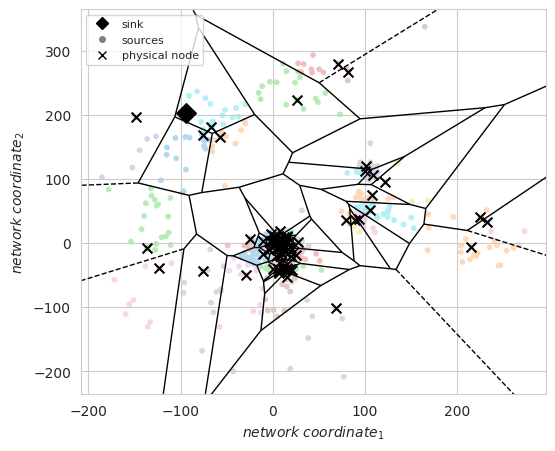

In [16]:
fig = plt.figure(figsize=(6, 5)).gca()
cluster_head_coords = coords[ch_indexes]

leach_color_list = sns.color_palette(n_colors=num_leach_clusters)
leach_colors = np.asarray(leach_color_list.as_hex())

fig.scatter(coords[0, 0], coords[0, 1], s=100, color=ccolor, marker=cmarker, zorder=100)
fig.scatter(cluster_head_coords[:, 0], cluster_head_coords[:, 1], s=50, color="black", marker="x", zorder=2)
fig.scatter(coords[:, 0], coords[:, 1], s=10, color=[lighten_color(x, 0.3) for x in leach_colors[leach_labels]],
            zorder=-1)

plt.legend(handles=[coordinator_label, worker_label, ch_label], loc="upper left", bbox_to_anchor=(0, 1), fontsize=8)

vor = Voronoi(cluster_head_coords)
voronoi_plot_2d(vor, ax=fig, point_size=16, color="red", show_vertices=False, show_points=False)

plt.xlabel('$network$ $coordinate_1$')
plt.ylabel('$network$ $coordinate_2$')
plt.xlim(X_dim)
plt.ylim(Y_dim)
plt.savefig("plots/atlas/leach.svg")
plt.show()

count    723.000000
mean     235.450017
std       64.277361
min        0.000000
25%      223.047556
50%      237.113171
75%      255.150914
max      492.962575
Name: latency_distribution, dtype: float64


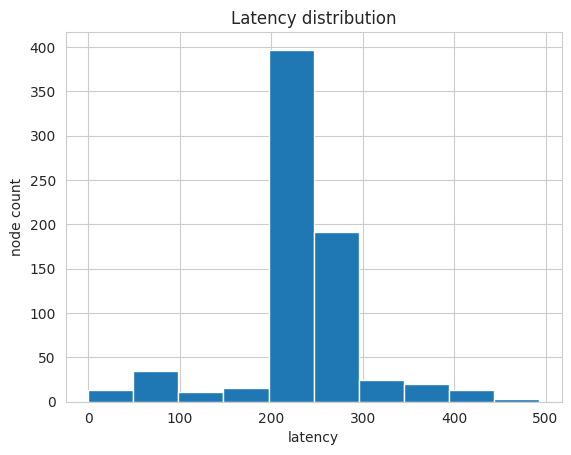

In [17]:
df_stats["latency_distribution"].hist()
plt.xlabel("latency")
plt.ylabel("node count")
plt.title("Latency distribution")
print(df_stats["latency_distribution"].describe())

In [18]:
eval_matrix["leach"] = df_stats.copy()

### Experiment 2a: NEMO Aggregation with Density-based Grouping

### Identify parameters

In [95]:
# fixed params
max_levels = 50
slot_col = "capacity_1"
weight_col = "weight"

# dynamic params
num_points = 9
start = 0.1
end = 0.9
hyperparam_values_1 = np.linspace(start, end, num_points)
hyperparam_values_2 = np.linspace(start, end, num_points)
X, Y = np.meshgrid(hyperparam_values_1, hyperparam_values_2)

# Initialize an array to store performance values
perc_lat_values = np.full_like(X, fill_value=np.nan)
mean_lat_values = np.full_like(X, fill_value=np.nan)

for i in range(num_points):
    for j in range(num_points):
        eval_dict, df_dict, opt_dict, limits_dict = evaluate_nemo(prim_df, [slot_col], weight_col, merge_factor=X[i, j], step_size=Y[i, j], max_levels=max_levels, with_eval=True)
        if limits_dict[slot_col]:
            continue
            
        sv = eval_dict[slot_col]["latency_distribution"].sort_values()
        perc_lat = round(sv.quantile(0.9), 2)
        mean_lat = round(sv.mean(), 2)
        print(perc_lat, mean_lat)

        perc_lat_values[i, j] = perc_lat
        mean_lat_values[i, j] = mean_lat

Starting nemo for: c=capacity_1, w=weight, l=50, step_size=0.1, merge_factor=0.1
Level 0 CH number:  722 Load: 5109
--------Balancing load for 7 clusters to 0
Level 1 CH number:  93 Load: 713
--------Balancing load for 1 clusters to 0
Level 2 CH number:  18 Load: 104
--------Balancing load for 1 clusters to 0
Level 3 CH number:  4 Load: 7
Evaluating for capacity_1
464.02 319.22
Starting nemo for: c=capacity_1, w=weight, l=50, step_size=0.1, merge_factor=0.2
Level 0 CH number:  722 Load: 5109
--------Balancing load for 7 clusters to 0
Level 1 CH number:  93 Load: 713
--------Balancing load for 1 clusters to 0
Level 2 CH number:  18 Load: 104
--------Balancing load for 1 clusters to 0
Level 3 CH number:  4 Load: 7
Evaluating for capacity_1
464.02 319.22
Starting nemo for: c=capacity_1, w=weight, l=50, step_size=0.1, merge_factor=0.30000000000000004
Level 0 CH number:  722 Load: 5109
--------Balancing load for 7 clusters to 0
Level 1 CH number:  93 Load: 713
--------Balancing load for 2 c

merge factor and step size for minimum latency (90P): (X=0.1, Y=0.30000000000000004) 306.57
merge factor and step size for minimum latency (mean): (X=0.1, Y=0.4) 249.67


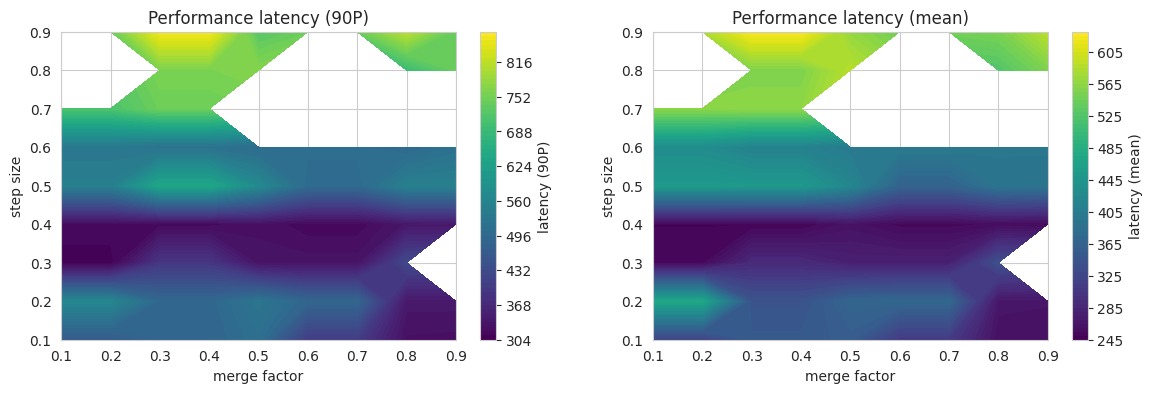

In [98]:
fig, axs = plt.subplots(1, 2, figsize=(14, 4))

for i, values in enumerate([perc_lat_values, mean_lat_values]):
    if i == 0:
        label = "latency (90P)"
    elif i == 1:
        label = "latency (mean)"
    else:
        label = "undefined"
        
    # Find the indices of the minimum Z value, ignoring nans
    min_index = np.unravel_index(np.nanargmin(values), values.shape)
    # Use the indices to get the corresponding X and Y values
    min_X = X[min_index]
    min_Y = Y[min_index]
    print(f"merge factor and step size for minimum {label}: (X={min_X}, Y={min_Y})", values[min_index])
    
    # Create a contour plot
    ax = axs[i]
    contour = ax.contourf(X, Y, values, levels=80, cmap='viridis')

    # Create a colorbar and set the label
    colorbar = plt.colorbar(contour)
    colorbar.set_label(label)
    
    ax.set_title(f"Performance {label}")
    ax.set_xlabel('merge factor')
    ax.set_ylabel('step size')

plt.savefig(f"plots/atlas/nemop_params_sl_{slot_col}_w_{weight_col}.svg", bbox_inches="tight")
plt.show()

In [101]:
param_dict = {
    "weight_1": {"merge_factor": 0.1, "step_size": 0.8},
    "weight_2": {"merge_factor": 0.3, "step_size": 0.7},
    "weight": {"merge_factor": 0.3, "step_size": 0.4},
    
    "capacity_100": { 
    "weight_1": {"merge_factor": 0.1, "step_size": 0.8},
    "weight_2": {"merge_factor": 0.3, "step_size": 0.7},
    "weight": {"merge_factor": 0.3, "step_size": 0.4}
    },
    "capacity_1": {
        "weight_1": {"merge_factor": 0.1, "step_size": 0.7},
        "weight_2": {"merge_factor": 0.1, "step_size": 0.8},
        "weight": {"merge_factor": 0.1, "step_size": 0.3}
    }
}

In [102]:
# for the eval for weights regarding latency
weight_cols = ["weight_1", "weight_2", "weight"]

for weight_col in weight_cols:
    eval_name = "nemo_dc" + "_" + weight_col
    eval_matrix[eval_name], df_dict, opt_dict, limits_dict = evaluate_nemo(prim_df, ["capacity_100", "capacity_1"],
                                                                           weight_col,
                                                                           merge_factor=param_dict[weight_col][
                                                                               "merge_factor"],
                                                                           step_size=param_dict[weight_col][
                                                                               "step_size"], with_eval=True)

Starting nemo for: c=capacity_100, w=weight_1, l=20, step_size=0.8, merge_factor=0.1
Level 0 CH number:  722 Load: 722
--------Balancing load for 7 clusters to 0
Level 1 CH number:  21 Load: 21
Evaluating for capacity_100
Starting nemo for: c=capacity_1, w=weight_1, l=20, step_size=0.8, merge_factor=0.1
Level 0 CH number:  722 Load: 722
--------Balancing load for 7 clusters to 0
Level 1 CH number:  16 Load: 16
Evaluating for capacity_1
Starting nemo for: c=capacity_100, w=weight_2, l=20, step_size=0.7, merge_factor=0.3
Level 0 CH number:  722 Load: 1444
--------Balancing load for 7 clusters to 0
Level 1 CH number:  39 Load: 78
--------Balancing load for 2 clusters to 0
Level 2 CH number:  3 Load: 6
Evaluating for capacity_100
Starting nemo for: c=capacity_1, w=weight_2, l=20, step_size=0.7, merge_factor=0.3
Level 0 CH number:  722 Load: 1444
--------Balancing load for 7 clusters to 0
Level 1 CH number:  28 Load: 56
--------Balancing load for 2 clusters to 0
Level 2 CH number:  5 Load: 

In [103]:
# for the plots and vanilla NEMO
slot_col = "capacity_100"
weight_col = "weight_1"
eval_name = "nemo_dc_" + weight_col 
df_dict_1, opt_dict_1, limits_dict_1 = evaluate_nemo(prim_df, [slot_col], weight_col, max_levels=1,
                                                     merge_factor=param_dict[weight_col]["merge_factor"],
                                                     step_size=param_dict[weight_col]["step_size"], with_eval=False)

# for the load evaluation
eval_matrix[eval_name], df_dict, opt_dict, limits_dict = evaluate_nemo(prim_df, slot_columns, weight_col,
                                                                       merge_factor=param_dict[weight_col][
                                                                           "merge_factor"],
                                                                       step_size=param_dict[weight_col]["step_size"],
                                                                       with_eval=True)

Starting nemo for: c=capacity_100, w=weight_1, l=1, step_size=0.8, merge_factor=0.1
Level 0 CH number:  722 Load: 722
--------Balancing load for 7 clusters to 0
Level 1 CH number:  21 Load: 21
Starting nemo for: c=capacity_100, w=weight_1, l=20, step_size=0.8, merge_factor=0.1
Level 0 CH number:  722 Load: 722
--------Balancing load for 7 clusters to 0
Level 1 CH number:  21 Load: 21
Evaluating for capacity_100
Starting nemo for: c=capacity_90, w=weight_1, l=20, step_size=0.8, merge_factor=0.1
Level 0 CH number:  722 Load: 722
--------Balancing load for 7 clusters to 0
Level 1 CH number:  20 Load: 20
Evaluating for capacity_90
Starting nemo for: c=capacity_80, w=weight_1, l=20, step_size=0.8, merge_factor=0.1
Level 0 CH number:  722 Load: 722
--------Balancing load for 7 clusters to 0
Level 1 CH number:  20 Load: 20
Evaluating for capacity_80
Starting nemo for: c=capacity_70, w=weight_1, l=20, step_size=0.8, merge_factor=0.1
Level 0 CH number:  722 Load: 722
--------Balancing load for 

In [104]:
df = df_dict[slot_col]
df

,oindex,x,y,type,cluster,total_weight,unbalanced_weight,used_weight,total_capacity,free_capacity,level,parent,load
0,0,-93.917515,202.161843,coordinator,-1,<NA>,<NA>,<NA>,50,29,2,<NA>,21
1,1,-133.101399,-123.417988,worker,5,1,0,1,50,50,0,18,0
2,2,77.039491,-208.571409,worker,5,1,0,1,50,50,0,18,0
3,3,-185.479238,102.680454,worker,6,1,0,1,50,50,0,360,0
4,4,-159.584229,-110.718603,worker,5,1,0,1,50,50,0,18,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
718,718,-36.457796,-36.644464,worker,0,1,0,1,50,50,0,28,0
719,719,5.153206,17.416845,worker,0,1,0,1,50,50,0,17,0
720,720,-11.880711,-3.653801,worker,0,1,0,1,50,50,0,29,0
721,721,-25.491140,-9.502637,worker,0,1,0,1,50,50,0,29,0


In [105]:
df[df["parent"] == df["oindex"]]

,oindex,x,y,type,cluster,total_weight,unbalanced_weight,used_weight,total_capacity,free_capacity,level,parent,load


In [106]:
df[df["parent"] == 0]

,oindex,x,y,type,cluster,total_weight,unbalanced_weight,used_weight,total_capacity,free_capacity,level,parent,load
5,5,-56.959355,165.495619,worker,4,1,0,1,50,44,1,0,6
6,6,-76.730572,169.207944,worker,4,1,0,1,50,10,1,0,40
7,7,-40.600106,155.266232,worker,4,1,0,1,50,24,1,0,26
14,14,-55.258133,173.148631,worker,4,1,0,1,50,10,1,0,40
17,17,-75.382547,177.278783,worker,4,1,0,1,50,24,1,0,26
18,18,-65.769385,142.574027,worker,4,1,0,1,50,14,1,0,36
28,28,-75.370551,161.622117,worker,4,1,0,1,50,10,1,0,40
29,29,-72.978407,147.260378,worker,4,1,0,1,50,10,1,0,40
30,30,-90.235922,164.303091,worker,4,1,0,1,50,10,1,0,40
31,31,-74.569421,151.411582,worker,4,1,0,1,50,10,1,0,40


In [107]:
# check -> should be empty
df_overloaded = df.groupby(['parent'])['used_weight'].sum().copy().reset_index()
df_join = df[["oindex", "total_capacity", "free_capacity"]]
result = pd.merge(df_join, df_overloaded, left_on='oindex', right_on='parent', how='inner')
result["delta"] = result["total_capacity"] - result["used_weight"]
result[result["delta"] < 0]

,oindex,total_capacity,free_capacity,parent,used_weight,delta


In [108]:
# check -> should be empty
result[result["delta"] != result["free_capacity"]]

,oindex,total_capacity,free_capacity,parent,used_weight,delta


In [109]:
result

,oindex,total_capacity,free_capacity,parent,used_weight,delta
0,0,50,29,0,21,29
1,5,50,44,5,6,44
2,6,50,10,6,40,10
3,7,50,24,7,26,24
4,14,50,10,14,40,10
5,17,50,24,17,26,24
6,18,50,14,18,36,14
7,28,50,10,28,40,10
8,29,50,10,29,40,10
9,30,50,10,30,40,10


In [110]:
#create greedy aggregation tree
cluster_coords = centroids
cluster_coords_with_crd = np.column_stack((c_coords, cluster_coords.T)).T

mst = prim_mst(cluster_coords_with_crd)

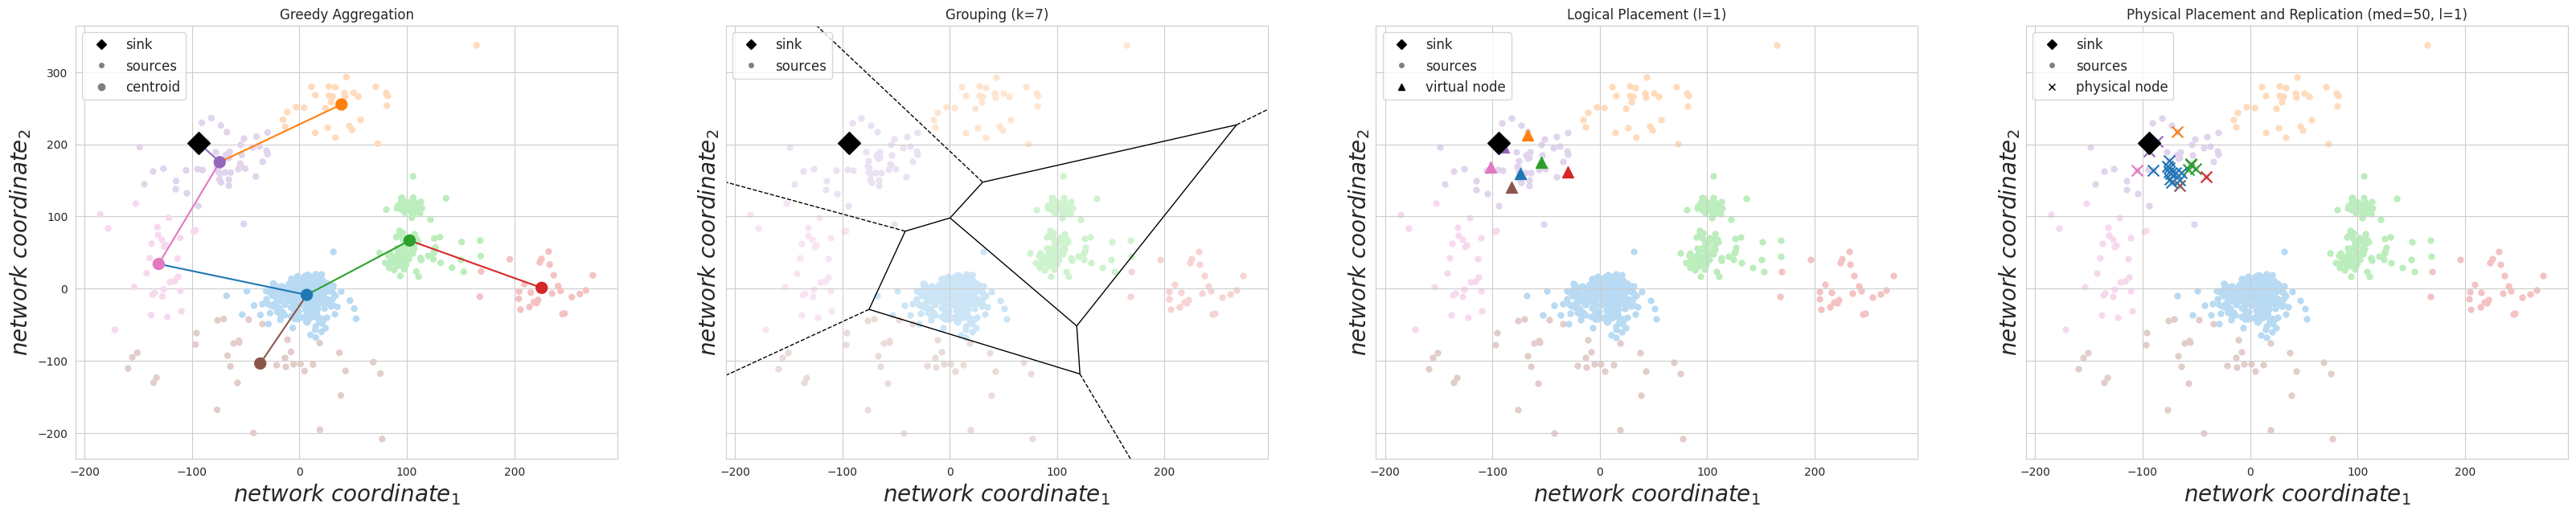

In [113]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(40, 7), sharex="all", sharey="all")

lval = 0.28
leg_size = 12
symbol_size = 100
scale_fac = 0.25
axis_label_size = 20

labels = prim_df["cluster"]

# plot greedy approach from MST
for i in range(1, len(mst)):
    point1 = cluster_coords_with_crd[i]
    point2 = cluster_coords_with_crd[mst[i]]
    x_values = [point1[0], point2[0]]
    y_values = [point1[1], point2[1]]
    ax1.plot(x_values, y_values, zorder=2, color=colors[i - 1])

ax1.scatter(coords[0, 0], coords[0, 1], s=2 * symbol_size, color=ccolor, marker=cmarker, zorder=10)
ax1.scatter(cluster_coords[:, 0], cluster_coords[:, 1], s=symbol_size, color=colors[:len(cluster_coords)], zorder=3)
# in case all coords shall be plotted
ax1.scatter(coords[:, 0], coords[:, 1], s=scale_fac * symbol_size,
            color=[lighten_color(x, lval) for x in colors[labels]])

lcentroid = Line2D([], [], color="blue", marker='o', linestyle='None', label='centroid')
ax1.legend(handles=[coordinator_label, worker_label, centroid_label], loc="upper left", bbox_to_anchor=(0, 1),
           fontsize=leg_size)

ax1.set_xlabel('$network$ $coordinate_1$', fontsize=axis_label_size)
ax1.set_ylabel('$network$ $coordinate_2$', fontsize=axis_label_size)
ax1.set_title('Greedy Aggregation')

#plot grouping
util.plot_topology(ax2, prim_df, colors, title='Grouping (k=' + str(opt_k) + ")", plot_voronoi=True, leg_size=leg_size,
                   symbol_size=symbol_size, scale_fac=scale_fac, axis_label_size=axis_label_size)

#plot logical nodes (optima) of different groups
# util.plot2(ax3, prim_df, df_dict[slot_col], colors, lval=lval, show_centroids=True)
util.plot_optimum(ax3, prim_df, opt_dict[slot_col], colors, lval=lval, plot_centroid=False, plot_lines=False,
                  leg_size=leg_size, symbol_size=symbol_size, scale_fac=scale_fac, axis_label_size=axis_label_size)
# plot physical nodes
util.plot(ax4, prim_df, df_dict_1[slot_col], colors, lval=lval, plot_centroids=False, plot_lines=False,
          leg_size=leg_size, symbol_size=symbol_size, scale_fac=scale_fac, axis_label_size=axis_label_size)

plt.xlim(X_dim)
plt.ylim(Y_dim)
ax3.set_title("Logical Placement (l=1)")
ax4.set_title("Physical Placement and Replication (med=" + first_med_label + ", l=1)")

plt.savefig("plots/atlas/nemo_phases.svg", bbox_inches="tight")
plt.show()

Starting nemo for: c=capacity_10, w=weight_2, l=1, step_size=0.7, merge_factor=0.3
Level 0 CH number:  722 Load: 1444
--------Balancing load for 7 clusters to 0
Level 1 CH number:  51 Load: 102
final assignment ------------------Load reached 0 -52
Starting nemo for: c=capacity_10, w=weight_2, l=2, step_size=0.7, merge_factor=0.3
Level 0 CH number:  722 Load: 1444
--------Balancing load for 7 clusters to 0
Level 1 CH number:  51 Load: 102
--------Balancing load for 2 clusters to 0
Level 2 CH number:  4 Load: 8
Starting nemo for: c=capacity_10, w=weight_2, l=3, step_size=0.7, merge_factor=0.3
Level 0 CH number:  722 Load: 1444
--------Balancing load for 7 clusters to 0
Level 1 CH number:  51 Load: 102
--------Balancing load for 2 clusters to 0
Level 2 CH number:  4 Load: 8


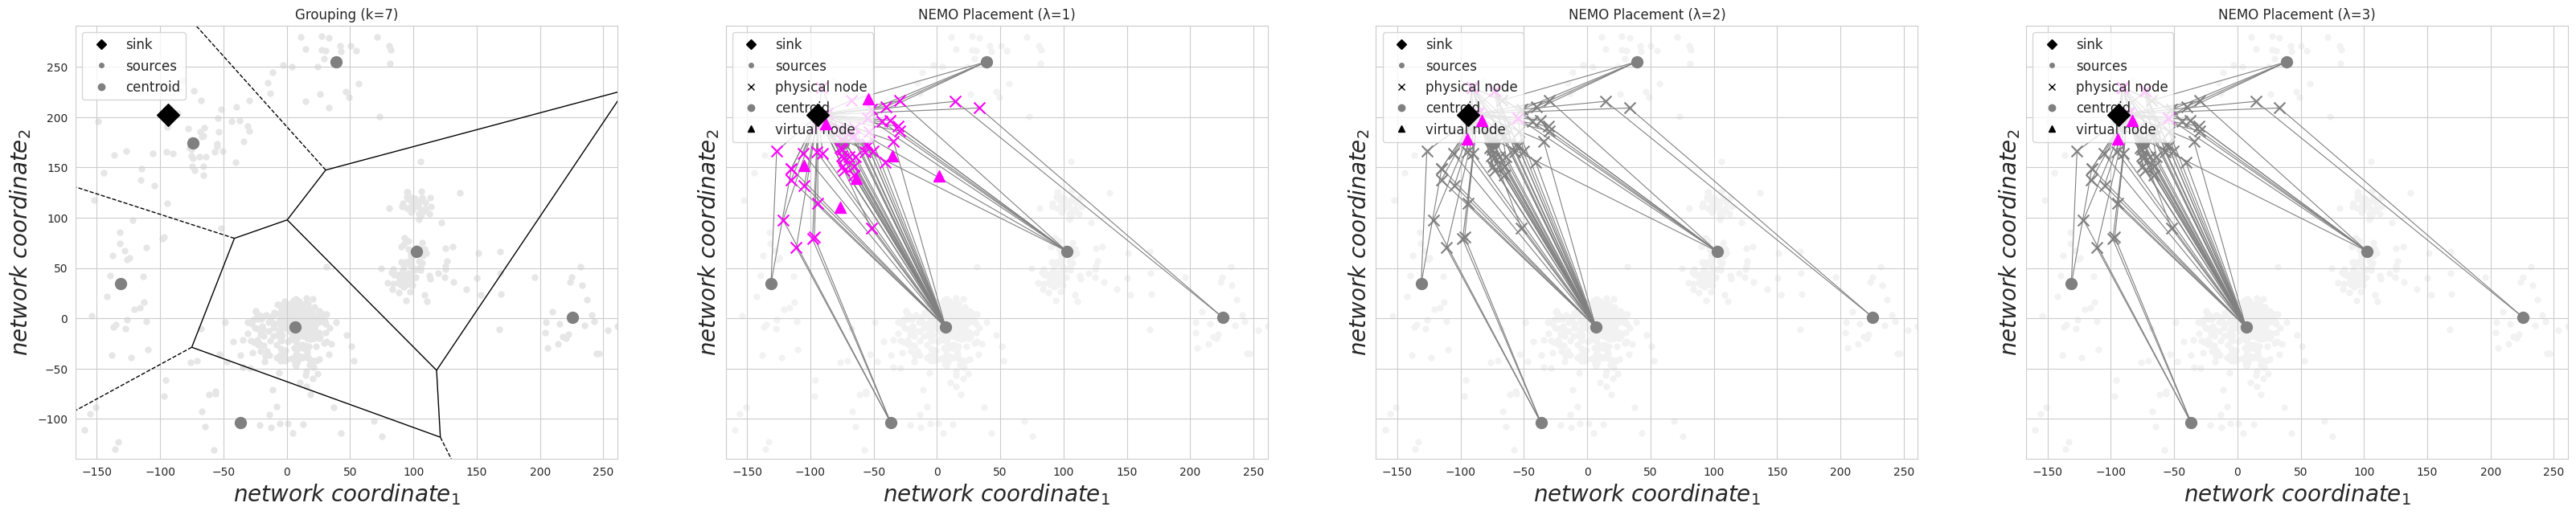

In [114]:
levels = [1, 2, 3]
fig, axs = plt.subplots(1, 4, figsize=(40, 7), sharex="all", sharey="all")
lval = 0.1
weight_col_plot = "weight_2"
slot_col_plot = "capacity_10"
single_color = "grey"

util.plot_topology(axs[0], prim_df, None, title='Grouping (k=' + str(opt_k) + ")", plot_voronoi=True, plot_centroid=True, leg_size=leg_size,
                   symbol_size=symbol_size, scale_fac=scale_fac, axis_label_size=axis_label_size,
                   point_color=single_color, centroid_color=single_color)

for i, level in enumerate(levels):
    df_dict_i, opt_dict_i, limits_dict_i = evaluate_nemo(prim_df, [slot_col_plot], weight_col_plot,
                                                         merge_factor=param_dict[weight_col_plot]["merge_factor"],
                                                         step_size=param_dict[weight_col_plot]["step_size"],
                                                         max_levels=level, with_eval=False)
    
    util.plot_with_single_color(axs[i + 1], prim_df, df_dict_i[slot_col_plot], single_color,
                                opt_dict=opt_dict_i[slot_col_plot], leg_size=leg_size, symbol_size=symbol_size,
                                scale_fac=scale_fac, axis_label_size=axis_label_size, lval=lval, plot_centroids=True,
                                plot_lines=True, highlight_color="magenta")
    axs[i+1].set_title(f"NEMO Placement (λ={str(level)})")

plt.show()

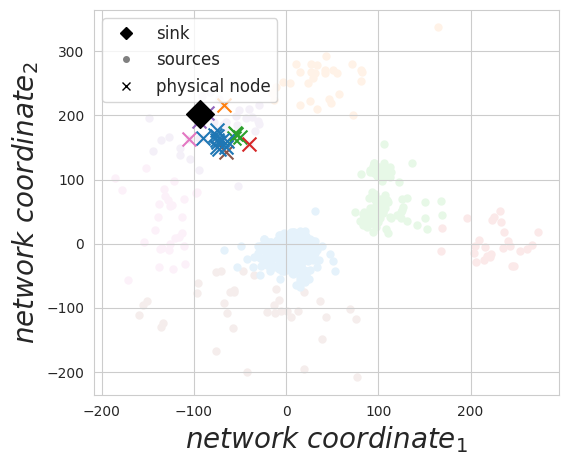

In [115]:
ax = plt.figure(figsize=(6, 5)).gca()

#uncomment this to plot nemo grouping
#ax2.scatter(coords[:, 0], coords[:, 1], s=10, color=[lighten_color(x, 0.2) for x in colors[labels]], zorder=-1)
#ax2.scatter(cluster_coords[:, 0], cluster_coords[:, 1], s=50, color=colors[:no_clusters], zorder=2)
#ax2.scatter(coords[0, 0], coords[0, 1], s=100, color=ccolor, marker=cmarker, zorder=1)
#ax2.set_title('Grouping (k=' + str(opt_k) + ")")
#fig.legend(handles=[coordinator_label, worker_label, centroid_label], loc="upper left", bbox_to_anchor=(0, 1), fontsize=8)

#uncomment this for nemo placement
util.plot(ax, prim_df, df_dict_1[slot_col], colors, lval=lval, plot_centroids=False, plot_lines=False)

#uncomment this for nemo redistribution
#util.plot(fig, new_paths_flat[slot_col], agg_dict_flat[slot_col], c_coords, cluster_coords, coords, colors, labels, changed_labels=reassigned_clussters, lval=lval)


ax.set_xlabel('$network$ $coordinate_1$')
ax.set_ylabel('$network$ $coordinate_2$')

plt.savefig("plots/atlas/nemo_placement.svg", bbox_inches="tight")

Distribution of workload:  2.3513 %


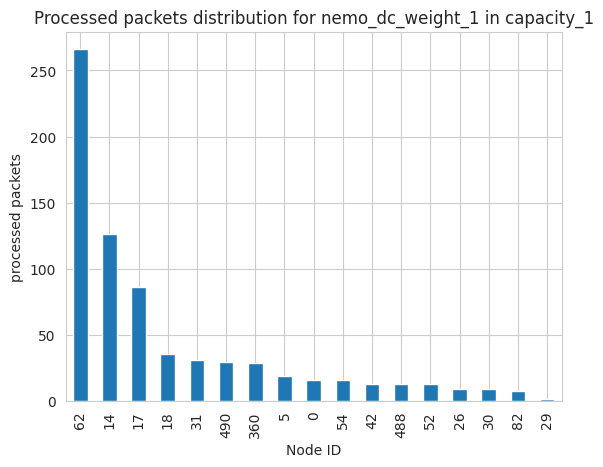

In [116]:
eval_col = list(eval_matrix[eval_name])[-1]
df_stats = eval_matrix[eval_name][eval_col]
df_packets = df_stats.loc[df_stats["received_packets"] > 0]["received_packets"].sort_values(ascending=False)
df_packets.plot.bar()

print("Distribution of workload: ", round(len(df_packets) / device_number * 100, 4), "%")
plt.xlabel("Node ID")
plt.ylabel("processed packets")
plt.title("Processed packets distribution for " + eval_name + " in " + str(eval_col))
plt.show()

### Experiment 3: Calculating the minimimal chain which is equivallent to the TSP
#### Corresponds to to the optimal chain of chain-based protocol solutions like PEGASIS or CREEC

In [117]:
# the adjacency matrix for the plane
df = prim_df.copy()
t_coords = coords[0::]
solver = AnnealingSolver()
route, valueBest, nCities, recordBest, recordNow = solver.solve_tsp(t_coords)

i:0, t(i):10.00, valueNow:51934.0, valueBest:51934.0
i:10, t(i):3.49, valueNow:35484.0, valueBest:35484.0
i:20, t(i):1.22, valueNow:30861.0, valueBest:30861.0
i:30, t(i):0.42, valueNow:28319.0, valueBest:28319.0
i:40, t(i):0.15, valueNow:25923.0, valueBest:25923.0
i:50, t(i):0.05, valueNow:24729.0, valueBest:24729.0
i:60, t(i):0.02, valueNow:23505.0, valueBest:23505.0


In [118]:
print(route)

[285 186 549 496  76 641  93 212 324 687 506 254 277 328 507 193 223 104
 623 618 205 485 615 616 710 439 619 620 486 622 621 596 400 258 631 307
 214 583 530 402 473 395 487 711 294 408 700 406 434 239 481 704 510 133
 672 593 580  71 284 588 667 605 163 656 632 539 494 135 283 660 466  74
 635 398 330 325 515  50 200 424 252 246 222 293 459 417 421 271 526 461
 534 159 184  69 514 480  79 690  22  10  86 276 278 419 438 331 681 665
 203 213 416 464 482  84  41 463 597 397 595 478 609 295 192 519 717 327
 407 531 129 604 247 132 423 300 366   5 568 565 362 134 501 359 491  53
 128  12  16  55 103 694  20 458 364  89  57 457 567 479  11  29  28 563
   6  52 444 389 377 576 571 288 306 603 608 475 536 310 566 476 692 376
 428 382   9 488  18  26 130 167 257 575 346  48 280 430  47  65   2 340
 339 208 218 543 370 579  60 386 500 164  99 109  78  73 380 453   7  23
  25 166 581 312 699 183 467 233 175 590  75 572 115  98 483 201 714 410
 172  46 472 677 107 264 433 535 574 689 251 497  7

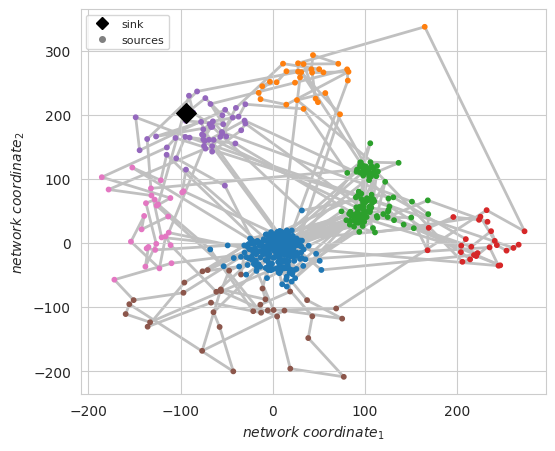

In [119]:
fig = plt.figure(figsize=(6, 5)).gca()

for i in range(0, len(route) - 1):
    point1 = coords[route[i]]
    point2 = coords[route[i + 1]]
    x_values = [point1[0], point2[0]]
    y_values = [point1[1], point2[1]]
    plt.plot(x_values, y_values, zorder=-1, color="silver", linewidth=2)

df.plot.scatter(x="x", y="y", c=colors[labels], s=10, ax=fig)
plt.scatter(coords[0, 0], coords[0, 1], s=100, marker=cmarker, color='black')

plt.legend(handles=[coordinator_label, worker_label], loc="upper left", bbox_to_anchor=(0, 1), fontsize=8)
plt.xlim(X_dim)
plt.ylim(Y_dim)
plt.xlabel('$network$ $coordinate_1$')
plt.ylabel('$network$ $coordinate_2$')
plt.savefig("plots/atlas/chain_50n.svg", bbox_inches="tight")
plt.show()

In [120]:
#first node is the coordinator
latency_hist = np.zeros(device_number)
received_packets_hist = np.zeros(device_number)
ind_cor = np.where(route == 0)[0][0]
print("Coordinator is on place ", ind_cor, " in route.")

for i in range(0, len(route)):
    #calculate euclidean distance which corresponds to the cost space (latency)
    dist = 0
    lat_route = []
    if i < ind_cor:
        lat_route = route[i:ind_cor + 1]
    elif i > ind_cor:
        lat_route = route[i:ind_cor - 1:-1]
    else:
        continue

    start_idx = lat_route[0]
    received_packets_hist[lat_route[1]] += 1
    for j in range(1, len(lat_route)):
        end_idx = lat_route[j]
        dist = dist + np.linalg.norm(coords[start_idx] - coords[end_idx])
        start_idx = end_idx
    latency_hist[i] = dist

statistics = {"latency_distribution": latency_hist,
              "received_packets": received_packets_hist}
df_stats = pd.DataFrame(statistics)

Coordinator is on place  694  in route.


In [121]:
print(df_stats["received_packets"])

0      2.0
1      1.0
2      1.0
3      1.0
4      1.0
      ... 
718    1.0
719    1.0
720    1.0
721    1.0
722    1.0
Name: received_packets, Length: 723, dtype: float64


count      723.000000
mean     10435.241001
std       6985.215529
min          0.000000
25%       4008.660811
50%       9528.212008
75%      17072.134141
max      22196.486330
Name: latency_distribution, dtype: float64


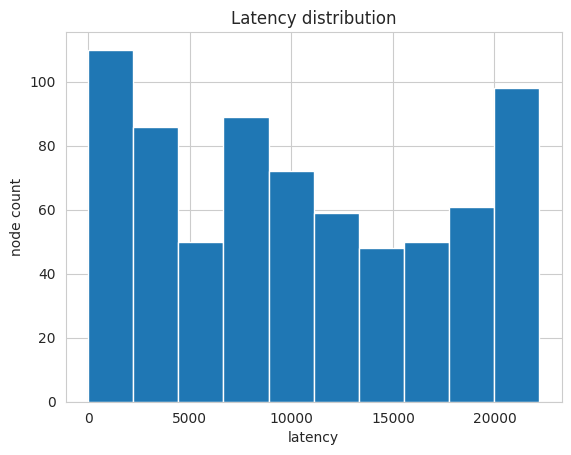

In [122]:
df_stats["latency_distribution"].hist()
plt.xlabel("latency")
plt.ylabel("node count")
plt.title("Latency distribution")
print(df_stats["latency_distribution"].describe())

count    723.000000
mean       0.998617
std        0.064445
min        0.000000
25%        1.000000
50%        1.000000
75%        1.000000
max        2.000000
Name: received_packets, dtype: float64


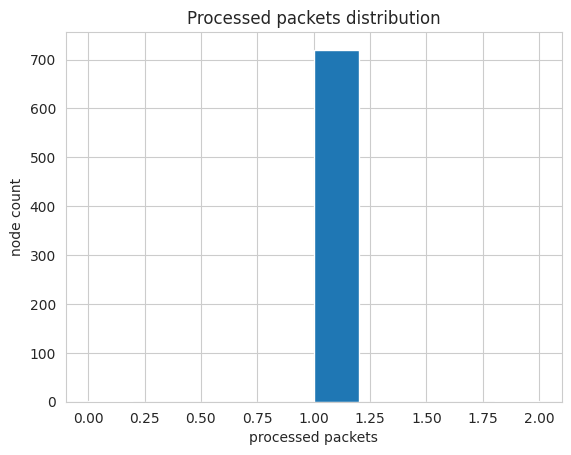

In [123]:
df_stats["received_packets"].hist()
plt.xlabel("processed packets")
plt.ylabel("node count")
plt.title("Processed packets distribution")
print(df_stats["received_packets"].describe())

eval_matrix["chain"] = df_stats.copy()

In [124]:
np.where(received_packets_hist > 1)

(array([0]),)

### Experiment 4: Calculating the minimum spanning tree like in PEDAP

In [125]:
df = prim_df.copy()
mst = prim_mst(coords)

In [126]:
print(mst)

[-1, 4, 340, 363, 338, 52, 17, 42, 364, 365, 59, 3, 38, 579, 119, 360, 8, 563, 366, 26, 117, 149, 458, 30, 16, 56, 82, 20, 83, 31, 6, 87, 105, 207, 116, 389, 496, 376, 361, 100, 44, 464, 5, 231, 505, 386, 703, 706, 275, 157, 398, 228, 62, 128, 0, 362, 15, 103, 19, 86, 140, 150, 87, 113, 347, 47, 661, 478, 315, 296, 322, 313, 374, 357, 312, 135, 312, 404, 109, 262, 380, 651, 0, 6, 41, 430, 361, 28, 671, 458, 174, 570, 554, 209, 654, 475, 352, 239, 352, 351, 471, 636, 516, 59, 519, 147, 438, 483, 125, 99, 268, 594, 139, 368, 688, 498, 576, 38, 219, 5, 471, 436, 662, 102, 37, 540, 164, 341, 469, 25, 15, 709, 597, 272, 10, 190, 129, 279, 668, 266, 388, 151, 37, 109, 500, 39, 116, 266, 468, 148, 375, 575, 226, 648, 309, 663, 98, 693, 538, 704, 306, 484, 592, 687, 144, 156, 247, 563, 213, 216, 237, 145, 627, 702, 318, 495, 611, 84, 405, 417, 412, 625, 395, 467, 69, 536, 76, 201, 212, 239, 655, 649, 326, 229, 676, 40, 177, 659, 524, 695, 243, 33, 250, 463, 716, 618, 481, 183, 666, 661, 608, 7

In [127]:
routes = createRoutes(mst)
print(routes[3])

[363, 429, 567, 130, 15, 360, 23, 30, 6, 17, 563, 19, 26, 82, 0]


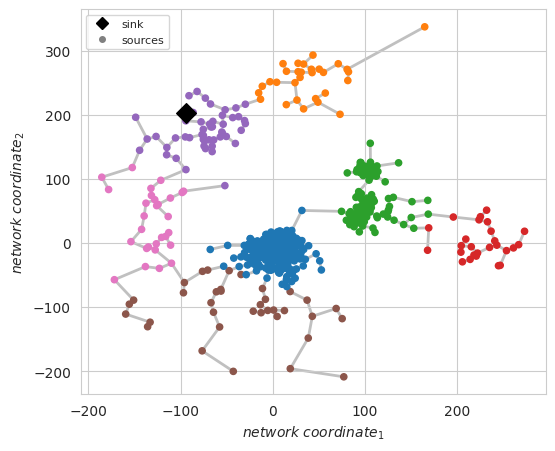

In [128]:
fig = plt.figure(figsize=(6, 5)).gca()

for i in range(1, len(mst)):
    point1 = coords[i]
    point2 = coords[mst[i]]
    x_values = [point1[0], point2[0]]
    y_values = [point1[1], point2[1]]
    plt.plot(x_values, y_values, zorder=-1, color="silver", linewidth=2)

df.plot.scatter(x="x", y="y", c=colors[labels], ax=fig)
fig.scatter(coords[0, 0], coords[0, 1], s=100, marker=cmarker, color='black')

plt.legend(handles=[coordinator_label, worker_label], loc="upper left", bbox_to_anchor=(0, 1), fontsize=8)
plt.xlim(X_dim)
plt.ylim(Y_dim)
plt.xlabel('$network$ $coordinate_1$')
plt.ylabel('$network$ $coordinate_2$')
plt.savefig("plots/atlas/mst.svg", bbox_inches="tight")
plt.show()

In [129]:
#first node is the coordinator
latency_hist = np.zeros(device_number)
for i in range(1, device_number):
    #calculate euclidean distance which corresponds to the cost space (latency)
    dist = 0
    lat_route = routes[i]
    start = i
    for j in range(0, len(lat_route)):
        end = lat_route[j]
        dist = dist + np.linalg.norm(coords[start] - coords[end])
        start = end
    latency_hist[i] = dist

received_packets_hist = np.zeros(device_number)
for i in range(1, device_number):
    received_packets_hist[mst[i]] += 1

statistics = {"latency_distribution": latency_hist,
              "received_packets": received_packets_hist}
df_stats = pd.DataFrame(statistics)

count    723.000000
mean     568.151247
std      195.489450
min        0.000000
25%      555.496153
50%      590.317887
75%      657.785530
max      979.138391
Name: latency_distribution, dtype: float64


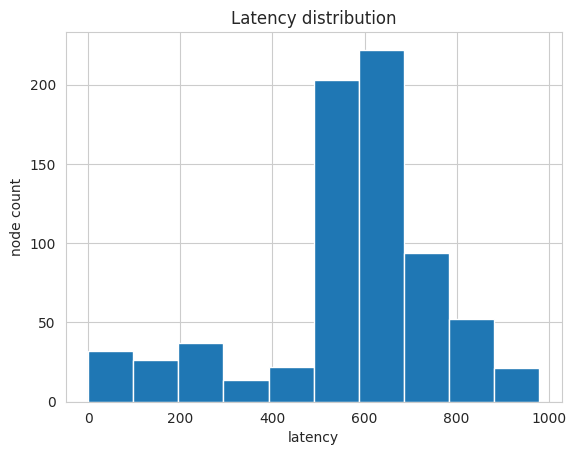

In [130]:
df_stats["latency_distribution"].hist()
plt.xlabel("latency")
plt.ylabel("node count")
plt.title("Latency distribution")
print(df_stats["latency_distribution"].describe())

Distribution of workload:  79.2531 %


Text(0.5, 1.0, 'Processed packets distribution')

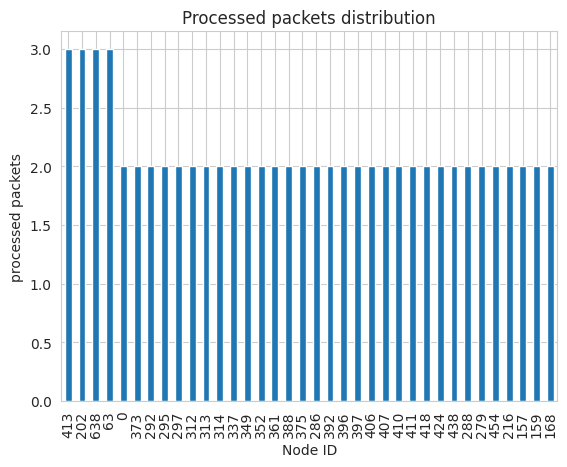

In [131]:
df_packets = df_stats.loc[df_stats["received_packets"] > 0]["received_packets"].sort_values(ascending=False)
print("Distribution of workload: ", round(len(df_packets) / device_number * 100, 4), "%")

df_packets = df_packets.head(int(round(device_number * 0.05)))
df_packets.plot.bar()

plt.xlabel("Node ID")
plt.ylabel("processed packets")
plt.title("Processed packets distribution")

In [132]:
eval_matrix["mst"] = df_stats.copy()

## Evaluation

In [133]:
eval_matrix.keys()

dict_keys(['dt', 'leach', 'nemo_dc_weight_2', 'nemo_dc_weight', 'nemo_dc', 'chain', 'mst', 'nemo_dc_weight_1'])

In [134]:
eval_matrix["nemo_dc"].keys()

dict_keys(['capacity_100', 'capacity_90', 'capacity_80', 'capacity_70', 'capacity_60', 'capacity_50', 'capacity_40', 'capacity_30', 'capacity_20', 'capacity_10', 'capacity_5', 'capacity_1'])

In [135]:
aggregation_fams = ["dt", "leach", "mst", "chain"]
heterogen_appr = ['nemo_dc', 'nemo_dc_weight_2', 'nemo_dc_weight']

#### Latency

In [152]:
heterogen_appr

['nemo_dc_weight_1', 'nemo_dc_weight_2', 'nemo_dc_weight']

In [153]:
colors_eval, light_colors_eval, palette_eval = util.get_color_list(11)

eval_colors = {
    "dt": colors_eval[0],
    "leach": colors_eval[1],
    "mst": colors_eval[2],
    "chain": colors_eval[3],
    "nemo": colors_eval[4],
    "nemo_base": colors_eval[4],
    "nemo_dc_base": colors_eval[4],
    "NEMO_base": colors_eval[4],
    "nemo_rc": colors_eval[5],
    "nemo_rc_base": colors_eval[5],
    "nemo (rdm groups)_base": colors_eval[5],
    "NEMO+redistribution": colors_eval[6],
    "nemo_pen": colors_eval[7],
    "nemo_pen_base": colors_eval[8],
    "nemo_dc_weight_1": colors_eval[6],
    "nemo_dc_weight_2": colors_eval[9],
    "nemo_dc_weight": colors_eval[10]
}

renaming_dict = {
    "nemo_dc_weight_1": "nemo (w=1,",
    "nemo_dc_weight_2": "nemo (w=2,",
    "nemo_dc_weight": "nemo (w=ln[1, 50],",
    "capacity_100": "m=" + first_med_label,
    "capacity_1": "m=" + last_med_label
}

In [154]:
eval_matrix["dt"]["latency_distribution"].mean()

225.7012365044757

In [160]:
min_lat = eval_matrix["dt"]["latency_distribution"]

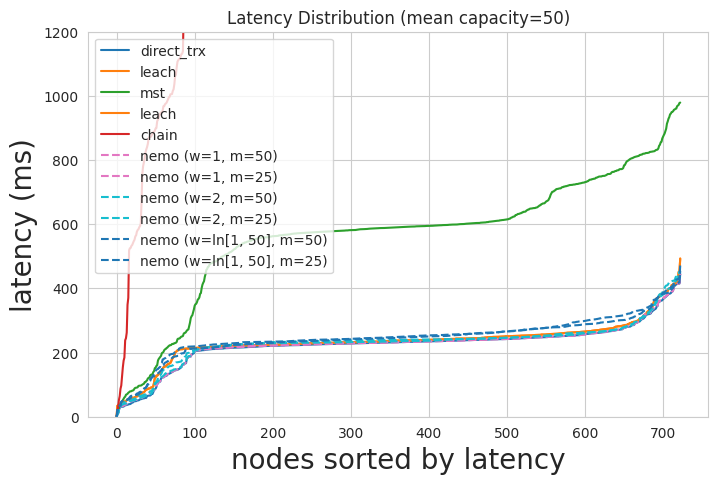

Means:  {'dt': 225.7, 'leach': 235.45, 'mst': 568.15, 'chain': 10435.24, 'nemo (w=1, m=50)': 226.84, 'nemo (w=1, m=25)': 226.97, 'nemo (w=2, m=50)': 233.15, 'nemo (w=2, m=25)': 232.11, 'nemo (w=ln[1, 50], m=50)': 244.69, 'nemo (w=ln[1, 50], m=25)': 249.78}
Quantiles:  {'dt': 276.26, 'leach': 284.71, 'mst': 781.92, 'chain': 21063.56, 'nemo (w=1, m=50)': 276.46, 'nemo (w=1, m=25)': 276.53, 'nemo (w=2, m=50)': 278.27, 'nemo (w=2, m=25)': 279.51, 'nemo (w=ln[1, 50], m=50)': 301.5, 'nemo (w=ln[1, 50], m=25)': 316.23}


In [167]:
fig, ax1 = plt.subplots(1, 1, figsize=(8, 5), sharey="all")
quant_dict = {}
mean_dict = {}

#plot baselines
for l in ["dt", "leach", "mst", "leach", "chain"]:
    orl = l
    sv = eval_matrix[l]["latency_distribution"].sort_values()
    #print("Mean latency ", l, ": ", round(eval_matrix[l]["latency_distribution"].mean(), 2))
    quant_dict[l] = round(eval_matrix[l]["latency_distribution"].quantile(0.9), 2)
    mean_dict[l] = round(eval_matrix[l]["latency_distribution"].mean(), 2)

    if l == "dt":
        l = "direct_trx"
    sv.plot(ax=ax1, linestyle="-", use_index=False, label=l, color=eval_colors[orl])

for approach in heterogen_appr:
    cl = approach
    emat = eval_matrix[approach]

    for capacity, df in emat.items():
        if capacity not in ["capacity_100", "capacity_1"]:
            continue
        l = renaming_dict[approach] + " " + renaming_dict[capacity] + ")"

        sv = df["latency_distribution"]
        # sanity check
        if ((sv - min_lat) < 0).any():
            print("Error!!!! Negative latency values")
        
        sv = sv.sort_values()
        quant_dict[l] = round(sv.quantile(0.9), 2)
        mean_dict[l] = round(sv.mean(), 2)
        sv.plot(ax=ax1, use_index=False, label=l, color=eval_colors[cl], linestyle="--")

ax1.set_xlabel('nodes sorted by latency')
ax1.set_ylabel('latency (ms)')

ax1.legend(loc="upper left", prop={'size': 10})
# Display a figure.
plt.ylim([0, 1200])

ax1.yaxis.label.set_size(20)
ax1.xaxis.label.set_size(20)

plt.savefig("plots/sim_1000/eval_latency.svg")

ax1.set_title('Latency Distribution (mean capacity=' + str(avg) + ")")
plt.show()
print("Means: ", mean_dict)
print("Quantiles: ", quant_dict)

#### Heterogeneity

In [168]:
aggregation_fams

['dt', 'leach', 'mst', 'chain']

In [175]:
eval_matrix_load = eval_matrix.copy()
eval_matrix_load.pop("nemo_dc_weight_2")
eval_matrix_load.pop("nemo_dc_weight")
eval_matrix_load.keys()

dict_keys(['dt', 'leach', 'nemo_dc', 'chain', 'mst', 'nemo_dc_weight_1'])

In [176]:
load_dict = {}
nn_dict = {}

for k, df in eval_matrix_load.items():
    if k in aggregation_fams:
        slot_list = []
        nn_list = []
        if k == "leach":
            all_slot_lists = []
            all_nn_lists = []
            for df in df_stats_leach:
                tmp_slot_list = []
                tmp_nn_list = []
                for colname in slot_columns:
                    df["av_capacity"] = prim_df[colname] - df["received_packets"]
                    tmp_df_sl = df[df["av_capacity"] < 0]
                    tmp_df_nn = df[df["av_capacity"] > 0]
                    tmp_slot_list.append(tmp_df_sl["av_capacity"].count())
                    tmp_nn_list.append(tmp_df_nn["av_capacity"].count())
                all_slot_lists.append(np.array(tmp_slot_list))
                all_nn_lists.append(np.array(tmp_nn_list))
            slot_list = (sum(all_slot_lists) / leach_runs).tolist()
            nn_list = (sum(all_nn_lists) / leach_runs).tolist()
        else:
            for colname in slot_columns:
                df["av_capacity"] = prim_df[colname] - df["received_packets"]
                tmp_df_sl = df[df["av_capacity"] < 0]
                tmp_df_nn = df[df["av_capacity"] > 0]
                slot_list.append(tmp_df_sl["av_capacity"].count())
                nn_list.append(tmp_df_nn["av_capacity"].count())
        load_dict[k] = slot_list
        nn_dict[k] = nn_list

In [177]:
load_dict

{'dt': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 'leach': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.1, 1.3, 2.4, 5.55, 18.05],
 'chain': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 63],
 'mst': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 50]}

In [178]:
load_dict = {}
nn_dict = {}

for k, df in eval_matrix_load.items():
    if k in aggregation_fams:
        slot_list = []
        nn_list = []
        if k == "leach":
            all_slot_lists = []
            all_nn_lists = []
            for df in df_stats_leach:
                tmp_slot_list = []
                tmp_nn_list = []
                for colname in slot_columns:
                    df["av_capacity"] = prim_df[colname] - df["received_packets"]
                    tmp_df_sl = df[df["av_capacity"] < 0]
                    tmp_df_nn = df[df["av_capacity"] > 0]
                    tmp_slot_list.append(tmp_df_sl["av_capacity"].count())
                    tmp_nn_list.append(tmp_df_nn["av_capacity"].count())
                all_slot_lists.append(np.array(tmp_slot_list))
                all_nn_lists.append(np.array(tmp_nn_list))
            slot_list = (sum(all_slot_lists) / leach_runs).tolist()
            nn_list = (sum(all_nn_lists) / leach_runs).tolist()
        else:
            for colname in slot_columns:
                df["av_capacity"] = prim_df[colname] - df["received_packets"]
                tmp_df_sl = df[df["av_capacity"] < 0]
                tmp_df_nn = df[df["av_capacity"] > 0]
                slot_list.append(tmp_df_sl["av_capacity"].count())
                nn_list.append(tmp_df_nn["av_capacity"].count())
        load_dict[k] = slot_list
        nn_dict[k] = nn_list

for k, mat in eval_matrix_load.items():
    if k in heterogen_appr:
        slot_list = []
        nn_list = []
        for colname in slot_columns:
            df = mat[colname]
            df["av_capacity"] = prim_df[colname] - df["received_packets"]
            tmp_df_sl = df[df["av_capacity"] < 0]
            tmp_df_nn = df[df["av_capacity"] >= 0]
            slot_list.append(tmp_df_sl["av_capacity"].count())
            nn_list.append(tmp_df_nn["av_capacity"].count())
        load_dict[k] = slot_list
        nn_dict[k] = nn_list

#for k, mat in eval_matrix.items():
#    if k in heterogen_appr:
#        slot_list = []
#        nn_list = []
#        for colname in slot_columns:
#            df = mat["base"]
#            df["av_capacity"] = prim_df[colname] - df["received_packets"]
#            tmp_df_sl = df[df["av_capacity"] < 0]
#            tmp_df_nn = df[df["av_capacity"] >= 0]
#            slot_list.append(tmp_df_sl["av_capacity"].count())
#            nn_list.append(tmp_df_nn["av_capacity"].count())
#        load_dict[k + "_base"] = slot_list
#        nn_dict[k + "_base"] = nn_list

In [179]:
load_dict.keys()

dict_keys(['dt', 'leach', 'chain', 'mst', 'nemo_dc_weight_1'])

In [180]:
agg_arr1 = []
for fam in load_dict.keys():
    agg_arr1.append(load_dict[fam])
    print("Fam: ", fam)
    print(load_dict[fam])

#agg_arr2 = []
#for fam in eval_matrix_load.keys():
#    agg_arr2.append(load_dict[fam + "_base"])
#mr = np.mean(np.array(agg_arr2), axis=0)
#load_dict["NEMO_base"] = mr
#print(mr)

Fam:  dt
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Fam:  leach
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.1, 1.3, 2.4, 5.55, 18.05]
Fam:  chain
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 63]
Fam:  mst
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 50]
Fam:  nemo_dc_weight_1
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


dt [50. 51. 50. 50. 49. 49. 47. 46. 43. 36. 31. 23.]
dt [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
leach [50. 51. 50. 50. 49. 49. 47. 46. 43. 36. 31. 23.]
leach [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.1, 1.3, 2.4, 5.55, 18.05]
chain [50. 51. 50. 50. 49. 49. 47. 46. 43. 36. 31. 23.]
chain [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 63]
mst [50. 51. 50. 50. 49. 49. 47. 46. 43. 36. 31. 23.]
mst [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 50]
nemo_dc_weight_1 [50. 51. 50. 50. 49. 49. 47. 46. 43. 36. 31. 23.]
nemo_dc_weight_1 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


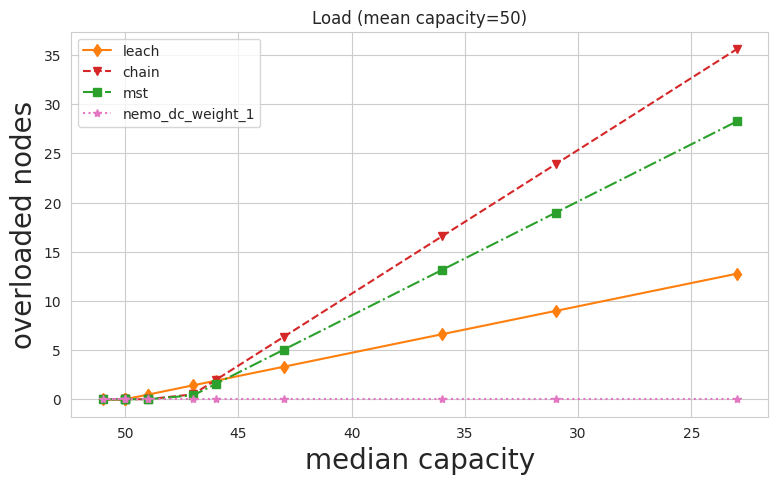

In [182]:
fig, ax = plt.subplots(figsize=(9, 5))
markers = ["d", "v", "s", "*", "^", "d", "v", "s", "*", "^"]
styles = ["-", "--", "-.", ":", "-.", "-"]
i = 0
for fam in load_dict.keys():
    vals = load_dict[fam]
    evcol = fam
    print(fam, medians)
    print(fam, vals)
    m, b = np.polyfit(medians, vals, 1)
    if fam == "dt":
        fam = "direct_trx"
        continue
    if fam == "nemo_dc":
        fam = "nemo"
    ax.plot(medians, (m * medians + b).clip(min=0), marker=markers[i], label=fam, linestyle=styles[i],
            color=eval_colors[evcol])
    i = i + 1

ax.invert_xaxis()
ax.set_xlabel("median capacity")
ax.set_ylabel("overloaded nodes")
#ax.set_yscale('log')
ax.legend()

ax.yaxis.label.set_size(20)
ax.xaxis.label.set_size(20)

plt.savefig("plots/atlas/eval_load_abs.svg")
ax.set_title("Load (mean capacity=" + str(avg) + ")")
plt.show()

In [183]:
load_dict.keys()

dict_keys(['dt', 'leach', 'chain', 'mst', 'nemo_dc_weight_1'])

leach - d #ff7f0e : [1.3888888888888888, 1.3888888888888888, 1.3888888888888888, 1.3888888888888888, 1.3888888888888888, 1.3888888888888888, 1.3888888888888888, 1.527777777777778, 1.8055555555555558, 3.3333333333333335, 7.708333333333334, 25.069444444444443]
chain -- v #d62728 : [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 8.737864077669903]
mst -. s #2ca02c : [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.850415512465375]
nemo_dc_weight_1 : * #e377c2 : [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


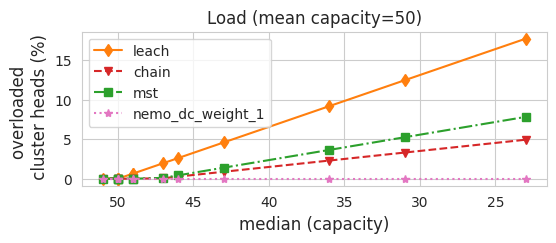

In [184]:
fig, ax = plt.subplots(figsize=(6, 2))
markers = ["d", "v", "s", "*", "^", "d", "v", "s", "*", "^"]
styles = ["-", "--", "-.", ":", "-.", "-"]
i = 0
for fam in load_dict.keys():
    vals = load_dict[fam]
    evcol = fam
    if fam == "dt":
        fam = "direct_trx"
        vals = [100 for x in vals]
        continue
    if fam == "leach":
        vals = [x / num_leach_clusters * 100 for x in vals]
    if fam == "mst":
        agg_points = (device_number - 1) / 2
        vals = [x / agg_points * 100 for x in vals]
    if fam == "chain":
        agg_points = device_number - 2
        vals = [x / agg_points * 100 for x in vals]
    if fam == "nemo_dc":
        fam = "nemo"
    m, b = np.polyfit(medians, vals, 1)
    print(fam, styles[i], markers[i], eval_colors[evcol], ":", vals)
    ax.plot(medians, (m * medians + b).clip(min=0), marker=markers[i], label=fam, linestyle=styles[i],
            color=eval_colors[evcol])
    i = i + 1

ax.invert_xaxis()
ax.set_xlabel("median (capacity)")
ax.set_ylabel("overloaded \n cluster heads (%)")
#ax.set_yscale('log')
ax.legend()

ax.yaxis.label.set_size(12)
ax.xaxis.label.set_size(12)

plt.savefig("plots/atlas/eval_load_perc.svg")
ax.set_title("Load (mean capacity=" + str(avg) + ")")
plt.show()

In [185]:
quant_dict

{'dt': 276.26,
 'leach': 284.71,
 'mst': 781.92,
 'chain': 21063.56,
 'nemo (w=1, m=50)': 276.46,
 'nemo (w=1, m=25)': 276.53,
 'nemo (w=2, m=50)': 278.27,
 'nemo (w=2, m=25)': 279.51,
 'nemo (w=ln[1, 50], m=50)': 301.5,
 'nemo (w=ln[1, 50], m=25)': 316.23}

In [186]:
mean_dict

{'dt': 225.7,
 'leach': 235.45,
 'mst': 568.15,
 'chain': 10435.24,
 'nemo (w=1, m=50)': 226.84,
 'nemo (w=1, m=25)': 226.97,
 'nemo (w=2, m=50)': 233.15,
 'nemo (w=2, m=25)': 232.11,
 'nemo (w=ln[1, 50], m=50)': 244.69,
 'nemo (w=ln[1, 50], m=25)': 249.78}